# A case study on Inverse Optimal Control under timely distributional shift

In [1]:
import numpy as np
import random as rd
import pickle as pkl
import matplotlib.pyplot as plt

from tqdm import tqdm

## Optimal Control Problem

In [2]:
import gekko
from gekko import GEKKO

In [3]:
def solve_optimal_control(observation, weights, time_horizon=1, time_steps=10,
                          max_absolute_position=1, max_absolute_velocity=1, max_absolute_acceleration=1):

    # defines initial states
    agent_pos_0, agent_vel_0, target_pos_0, _, hazard_pos_0,  _ = observation

    # defines model
    model = GEKKO(remote=False)
    model.time = np.linspace(0, time_horizon, time_steps)

    agent_pos_x = model.Var(agent_pos_0[0], lb=-max_absolute_position, ub=max_absolute_position)
    agent_pos_y = model.Var(agent_pos_0[1], lb=-max_absolute_position, ub=max_absolute_position)

    agent_vel_x = model.Var(agent_vel_0[0], lb=-max_absolute_velocity, ub=max_absolute_velocity)
    agent_vel_y = model.Var(agent_vel_0[1], lb=-max_absolute_velocity, ub=max_absolute_velocity)

    agent_acc_x = model.Var(lb=-max_absolute_acceleration, ub=max_absolute_acceleration)
    agent_acc_y = model.Var(lb=-max_absolute_acceleration, ub=max_absolute_acceleration)

    # model equations
    model.Equation(agent_pos_x.dt() == agent_vel_x)
    model.Equation(agent_pos_y.dt() == agent_vel_y)

    model.Equation(agent_vel_x.dt() == agent_acc_x)
    model.Equation(agent_vel_y.dt() == agent_acc_y)

    # model fixed final states
    model.fix_final(agent_pos_x, target_pos_0[0])
    model.fix_final(agent_pos_y, target_pos_0[1])

    # model cost
    cost = 0
    cost += weights[0]*((agent_pos_x - target_pos_0[0])**2 + (agent_pos_y - target_pos_0[1])**2)
    cost += weights[1]*((agent_pos_x - hazard_pos_0[0])**2 + (agent_pos_y - hazard_pos_0[1])**2)
    cost += weights[2]*(agent_vel_x**2 + agent_vel_y**2)
    cost += weights[3]*(agent_acc_x**2 + agent_acc_y**2)

    model.Minimize(cost)

    # solves
    model.options.IMODE = 6
    model.solve(disp=False)

    return (agent_pos_x.value, agent_pos_x.value), (agent_vel_x.value, agent_vel_y.value), (agent_acc_x.value, agent_acc_y.value)

## The Environment

<img src="dynamics_adv_5s_mpc_1s.png" alt="drawing" width="20%"/>
<img src="dynamics_rand_5s_mpc_1s.png" alt="drawing" width="20%"/>
<img src="environment_sample.gif" alt="drawing" width="20%"/>
<img src="environment_sample_traces.gif" alt="drawing" width="20%"/>

In [4]:
import gymnasium
import safe_mpc_environments

In [5]:
# 1000 steps 24fps ~40s
time_fps = 24
time_secs = 5

In [6]:
env = gymnasium.make('safe_mpc_environments/TargetHazardWorld-v0', render_mode = "human", )

observation, info = env.reset()

# evolve system
for i in range(1000):
    # sample random action
    action = env.action_space.sample()
    # step the environment
    observation, reward, terminated, truncated, info = env.step(action)

    # completion or error
    if terminated or truncated:
        observation, info = env.reset()

# closes environment
env.close()

In [6]:
# define (normalized) real weights
real_weights = np.array([1, -0.1, 0, 1])
real_weights = real_weights/np.linalg.norm(real_weights)

In [10]:
env = gymnasium.make('safe_mpc_environments/TargetHazardWorld-v0', render_mode = "human")

observation, info = env.reset()

# solves schema
_ , _, actions = solve_optimal_control(observation, time_horizon=time_secs, time_steps=time_fps*time_secs, weights=real_weights)

# evolve system
for i in range(24*time_secs):
    agent_action = np.array([actions[0][i],actions[1][i]])
    action = agent_action, np.zeros((2,)), np.zeros((2,))

    # updates state
    observation, reward, terminated, truncated, info = env.step(action)

    # completion or error
    if terminated or truncated:
        break

# closes environment
env.close()

## Inverse Optimal Control

### Sample Optimal Solutions

In [22]:
env = gymnasium.make('safe_mpc_environments/TargetHazardWorld-v0')

sample = []
n_samples = 1000

for i in tqdm(range(n_samples)):
    # gets a random initial state
    observation, _ = env.reset()

    # solves schema
    pos, vel, acc = solve_optimal_control(observation, time_horizon=time_secs, time_steps=time_fps*time_secs, weights=real_weights)

    # saves sample
    sample.append((observation, pos, vel, acc))

env.close()

100%|██████████| 1000/1000 [01:33<00:00, 10.69it/s]


In [7]:
filename = "inverse_oc_sample.pkl"

# # writes sample to file
# with open(filename, 'wb') as handle:
#     pkl.dump(sample, handle)

# loads sample from file
with open(filename, 'rb') as handle:
    sample = pkl.load(handle)

In [68]:
env = gymnasium.make('safe_mpc_environments/TargetHazardWorld-v0', render_mode = "human")

for observation, agent_pos, agent_vel, agent_acc  in sample[:3]:

    observation, info = env.reset(
        options={
            "agent_location": observation[0],
            "target_location": observation[2],
            "hazard_location": observation[4],}
    )

    # evolve system
    for i in range(24*time_secs):
        agent_action = np.array([agent_acc[0][i],agent_acc[1][i]])
        action = agent_action, np.zeros((2,)), np.zeros((2,))

        # updates state
        observation, reward, terminated, truncated, info = env.step(action)

        # completion or error
        if terminated or truncated:
            # observation, info = env.reset()
            break

env.close()

### Leaning Weights from Samples: Gradient-Based Estimation

We're interested in solving the bilevel problem $\min_c ||x_c - x^*||^2$ under the secondary optimal control problem of miniming $f(t,x,u,c) = \sum_i c_i f_i(t,x,u)$ given the system dynamics

Our idea is to use a gradient-based method considering $\frac{\partial}{\partial c}||x_c - x^*||^2 = 2(x_c - x^*) * \frac{\partial}{\partial c} x_c$, and where $\frac{\partial}{\partial c} x_c$ is estimated from sampling.

More preciselly, given the cost function $f(t,x,u,c)$, under suitable hipotesis, one can estimate the derivatives $\frac{\partial}{\partial c} f(t,x,u,c) = (\frac{f(t,x,u,c+\epsilon_i) - f(t,x,u,c-\epsilon_i)}{2\epsilon})_i$, from a symmetric two-point derivative.

In this case, one can estimate the optimal weights point $c^*$ through an Stochastic-Gradient-Descent iterative method.

In [8]:
def weight_mse_loss(weights, sample, control_cost=True):
    loss = 0
    count = 0
    for observation, agent_pos, agent_vel, agent_acc  in sample:
        # solves schema
        try:
            pos, vel, acc = solve_optimal_control(observation, time_horizon=time_secs, time_steps=time_fps*time_secs, weights=weights)
        except:
            continue
        
        count += 1
        for i in range(2):
            loss += np.sum((np.array(agent_pos[i])-np.array(pos[i]))**2)
            loss += np.sum((np.array(agent_vel[i])-np.array(vel[i]))**2)
            if control_cost:
                loss += np.sum((np.array(agent_acc[i])-np.array(acc[i]))**2)
    
    return loss/count


In [9]:
def estimate_derivatives(weights, sample, l0=None, delta=0.01, control_cost=True):
    dl = np.zeros(weights.shape)
    
    if l0 is None:
        l0 = weight_mse_loss(weights, sample, control_cost)

    for i in range(len(weights)):
        dw = np.zeros(weights.shape)
        dw[i] = delta
        dl[i] += weight_mse_loss(weights+dw, sample, control_cost)
         
    return (dl-l0)/delta


In [10]:
def learn_weights(weights, sample, n_epocs, steps_per_epoch, batch_size=10, delta=0.01, control_cost=True, stepsize = 0.01, tol = 10**(-6)):
    # saves learning logs
    logs = []

    # cicles
    for epoch in range(n_epocs):
        pbar = tqdm(range(steps_per_epoch))
        for i in pbar:
            # samples minibatch
            data = rd.sample(sample, batch_size)
            
            # updates current loss
            loss = weight_mse_loss(weights, data, control_cost)
            
            # updates history
            logs.append((loss, weights, data))

            # updates progress bar
            pbar.set_description("epoch: {}/{}, loss: {}, w: {}".format(epoch+1, n_epocs, loss, weights))
            
            # check if tol is reached
            if loss < tol:
                return weights, logs
            
            # estimate derivatives
            dldw_l = estimate_derivatives(weights, data, l0=loss, delta=delta, control_cost=control_cost)
            dldw_r = estimate_derivatives(weights, data, l0=loss, delta=-delta, control_cost=control_cost)
            dldw = (dldw_l + dldw_r)/2

            # updates weights from SGD
            weights = weights - stepsize*dldw

    # returns logs
    return weights, logs


In [15]:
# SGD parameters
tol = 1e-6
delta = 0.01
stepsize = 0.05

# train cicles
n_epocs = 30
steps_per_epoch = 100

# minibatch
batch_size = 20

# random initial weights
weights0 = np.random.rand(4)

In [30]:
# with control cost
control_cost = True
weights, logs_control_cost_true = learn_weights(weights0, sample, n_epocs, steps_per_epoch, batch_size, delta, control_cost, stepsize, tol)

epoch: 1/30, loss: 0.03347192660778437, w: [ 2.87192756 -0.29909484  0.67362621  2.56370718]: 100%|██████████| 100/100 [00:00<00:00, 2338.65it/s]
epoch: 2/30, loss: 0.008198748044405756, w: [ 2.83393361 -0.29100382  0.36727305  2.66782918]: 100%|██████████| 100/100 [00:00<00:00, 1858.48it/s]
epoch: 3/30, loss: 0.0029941047819350562, w: [ 2.80746586 -0.28533563  0.19832721  2.7149179 ]: 100%|██████████| 100/100 [00:00<00:00, 668.78it/s]
epoch: 4/30, loss: 0.0008450070252175937, w: [ 2.78967749 -0.28073177  0.10686928  2.73897171]: 100%|██████████| 100/100 [00:00<00:00, 1746.91it/s]
epoch: 5/30, loss: 0.00018176895329882306, w: [ 2.77906015 -0.27925638  0.05733429  2.75144859]: 100%|██████████| 100/100 [00:00<00:00, 2437.33it/s]
epoch: 6/30, loss: 8.77186153236911e-05, w: [ 2.77292894 -0.2782359   0.03067898  2.75820725]: 100%|██████████| 100/100 [00:00<00:00, 2281.40it/s]
epoch: 7/30, loss: 1.6508121832633722e-05, w: [ 2.76964668 -0.27733186  0.01640013  2.76182449]: 100%|██████████| 10

In [16]:
# without control cost
control_cost = False
weights, logs_control_cost_false = learn_weights(weights0, sample, n_epocs, steps_per_epoch, batch_size, delta, control_cost, stepsize, tol)

epoch: 1/30, loss: 0.020158267750965915, w: [ 2.41125063 -0.25459527  0.80828089  1.94989275]: 100%|██████████| 100/100 [41:20<00:00, 24.80s/it]
epoch: 2/30, loss: 0.009640413846672443, w: [ 2.39256517 -0.24695731  0.62239406  2.03988491]: 100%|██████████| 100/100 [40:47<00:00, 24.47s/it]
epoch: 3/30, loss: 0.007910035691296774, w: [ 2.37514961 -0.24180764  0.47954928  2.09899526]: 100%|██████████| 100/100 [39:05<00:00, 23.45s/it]
epoch: 4/30, loss: 0.005127543325182656, w: [ 2.35629017 -0.23686142  0.37071936  2.14269078]: 100%|██████████| 100/100 [42:22<00:00, 25.43s/it]
epoch: 5/30, loss: 0.003108916038954145, w: [ 2.33999294 -0.23707985  0.28428605  2.17370085]: 100%|██████████| 100/100 [40:24<00:00, 24.25s/it]
epoch: 6/30, loss: 0.001700144692007212, w: [ 2.32501274 -0.23693009  0.21911248  2.19730302]: 100%|██████████| 100/100 [35:50<00:00, 21.50s/it]
epoch: 7/30, loss: 0.0010651819639271737, w: [ 2.31294899 -0.23309006  0.16779896  2.21494276]: 100%|██████████| 100/100 [35:58<00

In [20]:
filename = "history.pkl"

# writes sample to file
with open(filename, 'wb') as handle:
    pkl.dump((logs_control_cost_true, logs_control_cost_false), handle)

# loads sample from file
with open(filename, 'rb') as handle:
    logs_control_cost_true, logs_control_cost_false = pkl.load(handle)

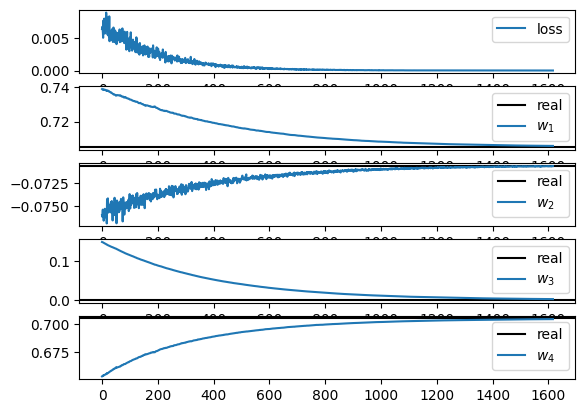

In [24]:
losses_, weights_, data_ = zip(*logs_control_cost_false)

losses_ = np.array(losses_)
weights_ = np.array(weights_)
for i in range(weights_.shape[0]):
    weights_[i,:] = weights_[i,:]/np.linalg.norm(weights_[i,:])

fig, ax = plt.subplots(5)

k=300

# plot losses
ax[0].plot(losses_[k:], label="loss")
ax[0].legend()

# plot weigts convergence
for i in range(len(weights)):
    ax[i+1].axhline(y=real_weights[i], label="real", c="k")
    ax[i+1].plot(weights_[k:,i], label="$w_{}$".format(i+1))
    ax[i+1].legend()

plt.show()

### Discussion: Costs Structure

A curiosity that naturally arises is about the structure of the loss studied related to the weights: is it subdiferentiable? Is it convex?

In [11]:
n = 100
m = real_weights.shape[0]

losses = np.zeros((n, m))
interval = np.linspace(-1,1, n)

for i in tqdm(range(n)):
    for j in range(m):
        weights = real_weights.copy()
        weights[j] = interval[i]
        losses[i,j] = weight_mse_loss(weights, sample[:50])


100%|██████████| 100/100 [42:55<00:00, 25.75s/it]


In [13]:
filename = "losses.pkl"

# # writes sample to file
# with open(filename, 'wb') as handle:
#     pkl.dump(losses, handle)

# loads sample from file
with open(filename, 'rb') as handle:
    losses = pkl.load(handle)

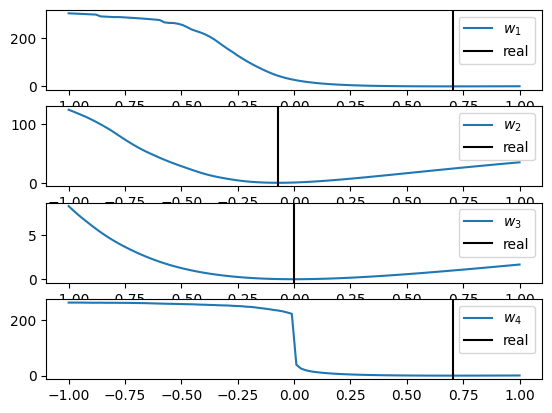

In [23]:
fig, ax = plt.subplots(losses.shape[1])

for i in range(losses.shape[1]):
    ax[i].plot(interval, losses[:,i], label="$w_{}$".format(i+1))
    ax[i].axvline(x=real_weights[i], label="real", c='k')
    ax[i].legend()


## MPC and Forwards Adaptive Motion

The main discussion of this work is about the use of IOC for robust generalization.

In this section, we show how this method can be conbined with MPC for robust adaptive motion.

Reference: https://www.syscop.de/files/2020ss/NOC/book-NOCSE.pdf

<!-- ![alt text](dynamics_adv_5s_mpc_1s.gif =250x250) ![alt text](dynamics_rand_5s_mpc_1s.gif) ![alt text](dynamics_static_5s_optimal.gif)  -->

<img src="dynamics_rand_5s_mpc_1s_alternative.png" alt="drawing" width="20%"/>
<img src="dynamics_adv_5s_mpc_1s.gif" alt="drawing" width="20%"/>
<img src="dynamics_rand_5s_mpc_1s.gif" alt="drawing" width="20%"/>
<img src="dynamics_static_5s_optimal.gif" alt="drawing" width="20%"/>



In [ ]:
time_secs = 1

In [27]:
env = gymnasium.make('safe_mpc_environments/TargetHazardWorld-v0', render_mode = "human")

observation, info = env.reset()

# solves schema
_ , _, actions = solve_optimal_control(observation, time_horizon=time_secs, time_steps=time_fps*time_secs, weights=real_weights)

# evolve system
for i in range(24*time_secs):
    agent_action = np.array([actions[0][i],actions[1][i]])
    action = agent_action, np.zeros((2,)), np.zeros((2,))

    # updates state
    observation, reward, terminated, truncated, info = env.step(action)

    # completion or error
    if terminated or truncated:
        break

# closes environment
env.close()

In [33]:
env = gymnasium.make('safe_mpc_environments/TargetHazardWorld-v0', render_mode = "human")

observation, info = env.reset()

# solves schema
_ , _, actions = solve_optimal_control(observation, time_horizon=time_secs, time_steps=time_fps*time_secs, weights=real_weights)

# evolve system
for i in range(24*time_secs):
    agent_action = np.array([actions[0][i],actions[1][i]])
    action = agent_action, np.zeros((2,)), np.zeros((2,))

    # updates state
    observation, reward, terminated, truncated, info = env.step(action)

    # completion or error
    if terminated or truncated:
        break

# closes environment
env.close()

In [22]:
time_secs = 10
time_secs_mpc = 1

In [26]:
env = gymnasium.make('safe_mpc_environments/TargetHazardWorld-v0', render_mode = "human")

observation, info = env.reset()

# evolve system
c = 1
for i in range(time_fps*time_secs):

    agent_location =  observation[0]
    target_location = observation[2]
    hazard_location = observation[4]
    d0 = (agent_location[0]- target_location[0])**2 + (agent_location[1]- target_location[1])**2
    
    time_initial = time_fps*time_secs-i
    last_time = min(time_initial, time_fps*time_secs_mpc)
    rd = (time_initial-last_time)/time_initial
    
    rd = d0*rd

    try:
        _ , _, actions = solve_optimal_control(observation, time_horizon=last_time/time_fps, time_steps=int(last_time),
                                           weights=real_weights, final_distance=rd)
        c = 1
    except:
        c += 1

    # agent_action = np.array([actions[0][1],actions[1][1]])
    # action = agent_action, np.zeros((2,)), np.zeros((2,))
    action = list(env.action_space.sample())
    action[0] = np.array([actions[0][1],actions[1][1]])
    action[1] = np.zeros(2)
    action[2] = np.clip((observation[0] + observation[2])/2 - observation[4], -0.1, 0.1)

    # updates state
    observation, reward, terminated, truncated, info = env.step(action)

    # completion or error
    if terminated or truncated:
        break

# closes environment
env.close()

In [19]:
env.close()

### Discussion: Short-Sightedness versus Practicality


<img src="dynamics_static_5s_mpc_05s.png" alt="drawing" width="20%"/>
<img src="dynamics_static_5s_mpc_1s.png" alt="drawing" width="20%"/>
<img src="dynamics_static_5s_mpc_2s.png" alt="drawing" width="20%"/>
<img src="dynamics_static_5s_optimal.png" alt="drawing" width="20%"/>

